<h2 style='color: orange'>Équipe: Louis & Emire</h2>

# Index

1. [Régression linéaire vs DNN](./projet_tp6_rc_dnn_louis_emire.ipynb)
2. [Régression linéaire vs Auto-Encodeur linéaire](./projet_tp6_rc_lae_louis_emire.ipynb)
3. [PCA 2D & Auto-Encodeur linéaire](./projet_tp6_pca2d_lae_louis_emire.ipynb)

#### B. Pour la régression entre la régression linéaire et un Auto-Encodeur, quelle méthode fonctionne le mieux et pourquoi?


In [12]:
# Librairies
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import itertools
from torch import nn
from utils.DataSet import DataSet
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Adding initial project root to path

path_to_module = '../'

# Add this path to sys.path
if path_to_module not in sys.path:
    sys.path.insert(0, path_to_module)

import common.engines as engines

In [4]:
# Data importation and pre-processing

data_set = DataSet('./data/TCGA_TPM_hv_subset.h5')

figures_directory = "./figures/project"

data = data_set.get_data('data', float)

genes = data_set.get_data('cols', str)
labels = data_set.get_data('labels', str)
rows = data_set.get_data('rows', str)

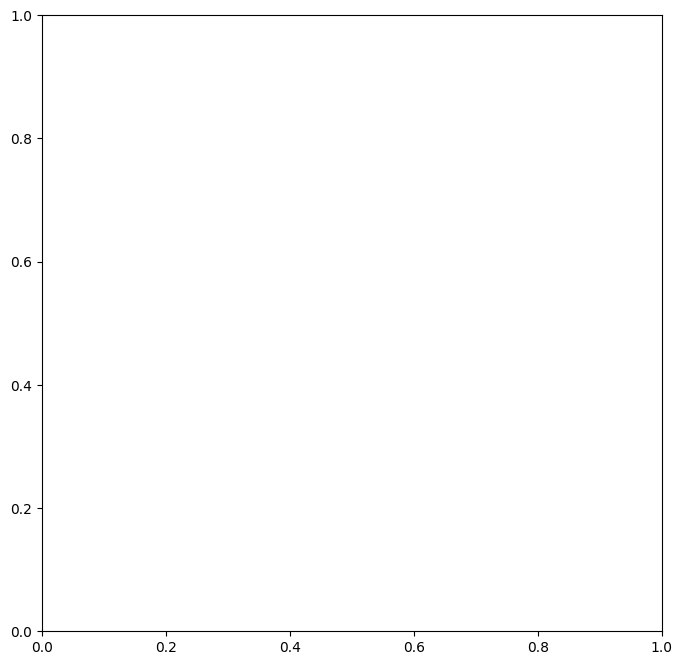

In [24]:
fig, axs = plt.subplots(1, 1, figsize = (8, 8))

#### Régression Logistique

In [6]:
max_iter = 100
X_train, X_test, Y_train, Y_test = train_test_split(data.T, labels, test_size= 0.2)
log_clf = RidgeClassifier(alpha=1e-4, solver ="lsqr", max_iter = max_iter)
log_clf.fit(X_train, Y_train)

train_set_accuracy = round((np.mean(log_clf.predict(X_train) == Y_train)), 2) * 100
test_set_accuracy = round((np.mean(log_clf.predict(X_test) == Y_test)), 2) * 100

print(f"Accuracy on train set (n = {X_train.shape[0]}): {train_set_accuracy}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {test_set_accuracy}%")
print(f"Number of errors : {(np.sum(log_clf.predict(X_test) != Y_test)) }")

KeyboardInterrupt: 

Confusion matrix

In [ ]:
cm = confusion_matrix(log_clf.predict(X_test),  Y_test)

axs[0,0].imshow(cm, cmap='Oranges', vmin=cm.min(), vmax=cm.max())
axs[0,0].set_xticks(np.arange(len(np.unique(labels))), labels = np.unique(labels), rotation = 45, ha='right')
axs[0,0].set_yticks(np.arange(len(np.unique(labels))), labels = np.unique(labels))
axs[0,0].set_xlabel("Predicted Labels", fontsize=12)
axs[0,0].set_ylabel("True Labels", fontsize=12)
axs[0,0].set_title("Ridge classifier confusion matrix on test set", fontsize=14)

thresh = cm.max() / 1.5

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        axs[0,0].text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

Errors plot


In [ ]:
# Get predictions
predictions = log_clf.predict(X_test)

# Find indices where predictions and actual values differ
error_indices = np.where(predictions != Y_test)[0]

# Adjust this based on your actual data
axs[1,0].scatter(X_test[error_indices, 0], X_test[error_indices, 1], color='orange', label='Errors')

# Optionally, plot correct predictions for comparison
correct_indices = np.where(predictions == Y_test)[0]
axs[1,0].scatter(X_test[correct_indices, 0], X_test[correct_indices, 1], color='#4B0082', alpha=0.5, label='Correct')

axs[1,0].set_xlabel('RC 1', fontsize=12)
axs[1,0].set_ylabel('RC 2', fontsize=12)
axs[1,0].set_title(f'Ridge classifier errors plot on test set\nAccuracy : {test_set_accuracy}%, Iters = {max_iter}', fontsize=14)
axs[1,0].legend()

#### Auto-Endcoder

In [15]:
### fonction d'initialisation du reseau
def linear_auto_encoder(insize, outsize, bnsize, width=500):
    model = nn.Sequential(
    nn.Linear(insize,width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, bnsize, bias = False), 
    nn.Linear(bnsize, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, outsize, bias = False))
    return model, model[0:3]


def train_linear_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 0.0001):
    DNN, encoder = linear_auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),3)} - acc : {round(float(tr_acc),3)} Test acc : {round(tst_acc,3)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)

In [16]:
nepochs = 100

lr = 1e-4

lblbin = LabelBinarizer()

targets = torch.Tensor(lblbin.fit_transform(labels))

X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(data.T), targets, test_size=0.2)

insize = X_train.shape[1]

y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())

y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

# mm, encoder = linear_auto_encoder(insize, insize, 2)

In [19]:
mm, tr_losses, tst_losses, tr_accs, tst_accs  = train_linear_auto_encoder(insize, 2, X_train, X_test, nepochs = nepochs, lr = lr)

Loss 0 Train - loss : 0.968 - acc : -0.016 Test acc : -0.016
Loss 10 Train - loss : 0.991 - acc : 0.027 Test acc : 0.027
Loss 20 Train - loss : 0.919 - acc : 0.051 Test acc : 0.051
Loss 30 Train - loss : 0.566 - acc : 0.33 Test acc : 0.329
Loss 40 Train - loss : 0.26 - acc : 0.693 Test acc : 0.692
Loss 50 Train - loss : 0.17 - acc : 0.809 Test acc : 0.807
Loss 60 Train - loss : 0.146 - acc : 0.838 Test acc : 0.837
Loss 70 Train - loss : 0.137 - acc : 0.848 Test acc : 0.847
Loss 80 Train - loss : 0.134 - acc : 0.852 Test acc : 0.85
Loss 90 Train - loss : 0.133 - acc : 0.853 Test acc : 0.851
Loss 99 Train - loss : 0.133 - acc : 0.853 Test acc : 0.852


In [20]:
LAE_X_train = mm[0:3](X_train).detach().numpy()
LAE_X_test = mm[0:3](X_test).detach().numpy()

y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())
y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

Learning curves

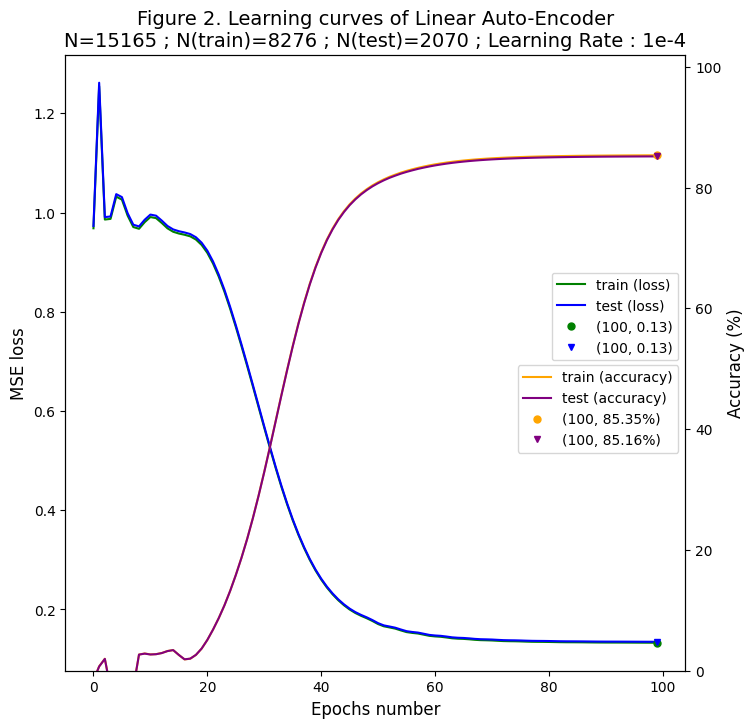

In [38]:
fig, axs = plt.subplots(1, 1, figsize = (8, 8))

axs.cla()

markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])

steps = np.arange(len(tr_losses))

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='orange', lw=2, linestyle='--'),
                Line2D([0], [0], color='purple', lw=2, linestyle='--')]

# First plot (Losses) on axs[0, 1]
axs.plot(steps, tr_losses, label="train (loss)", color='green')
axs.plot(steps, tst_losses, label="test (loss)", color='blue')
axs.plot(steps[-1], tr_losses[-1], 'go', markersize=5, label=f'({steps[-1] + 1}, {tr_losses[-1]:.2f})')
axs.plot(steps[-1], tst_losses[-1], 'bv', markersize=5, label=f'({steps[-1] + 1}, {tst_losses[-1]:.2f})')
axs.set_ylabel("MSE loss", fontsize=12)
axs.set_xlabel("Epochs number", fontsize=12)
axs.legend(loc='center right', bbox_to_anchor=(1, 0.575))

# Second plot (Accuracies) on the same subplot, but using a secondary y-axis
sec_ax = axs.twinx()
sec_ax.plot(steps, tr_accs * 100, label="train (accuracy)", color='orange')
sec_ax.plot(steps, tst_accs * 100, label="test (accuracy)", color='purple')
sec_ax.plot(steps[-1], tr_accs[-1] * 100, 'o', color='orange', markersize=5, label=f'({steps[-1] + 1}, {tr_accs[-1]*100:.2f}%)')
sec_ax.plot(steps[-1], tst_accs[-1] * 100, 'v', color='purple', markersize=5, label=f'({steps[-1] + 1}, {tst_accs[-1]*100:.2f}%)')
sec_ax.set_ylabel("Accuracy (%)", fontsize=12)
sec_ax.set_ylim((0, 102))
sec_ax.legend(loc='center right', bbox_to_anchor=(1, 0.425))

# Set the title for the combined plot
axs.set_title(f"Figure 2. Learning curves of Linear Auto-Encoder\nN={data.T.shape[1]} ; N(train)={X_train.shape[0]} ; N(test)={X_test.shape[0]} ; Learning Rate : 1e-4", fontsize=14)

fig.savefig(f'{figures_directory}/rc_lae_comparative_analysis_figures.svg', format='svg', bbox_inches='tight')

Hexbin plot

In [ ]:
y_tst_out = mm(X_test)
outs = y_tst_out.flatten().detach().numpy()
trues = X_test.flatten().detach().numpy()
corr =  pearsonr(outs, trues).statistic

axs[0, 1].grid(visible=True, alpha=0.5, linestyle="--")
lims = max([max(outs), max(trues)])
axs[0, 1].plot([0, lims],[0, lims], color="blue", alpha=0.5, linestyle="--")

# Create a hexbin plot and capture its return value
hb = axs[0, 1].hexbin(outs, trues, bins="log")

# Set labels and title
axs[0, 1].set_xlabel("Predicted Expressions (normalized TPM)", fontsize=12)
axs[0, 1].set_ylabel("True expressions", fontsize=12)
axs[0, 1].set_title(f"Auto-Encoder performance of reconstruction on test set\nPearson Correlation: {round(corr,4)}", fontsize=14)

# Create a colorbar for the hexbin plot
cbar = fig.colorbar(hb, ax=axs[0, 1], pad=0.01)
cbar.set_label("log10(N)", fontsize=12, labelpad=10)

(31391550,) (31391550,)


Group

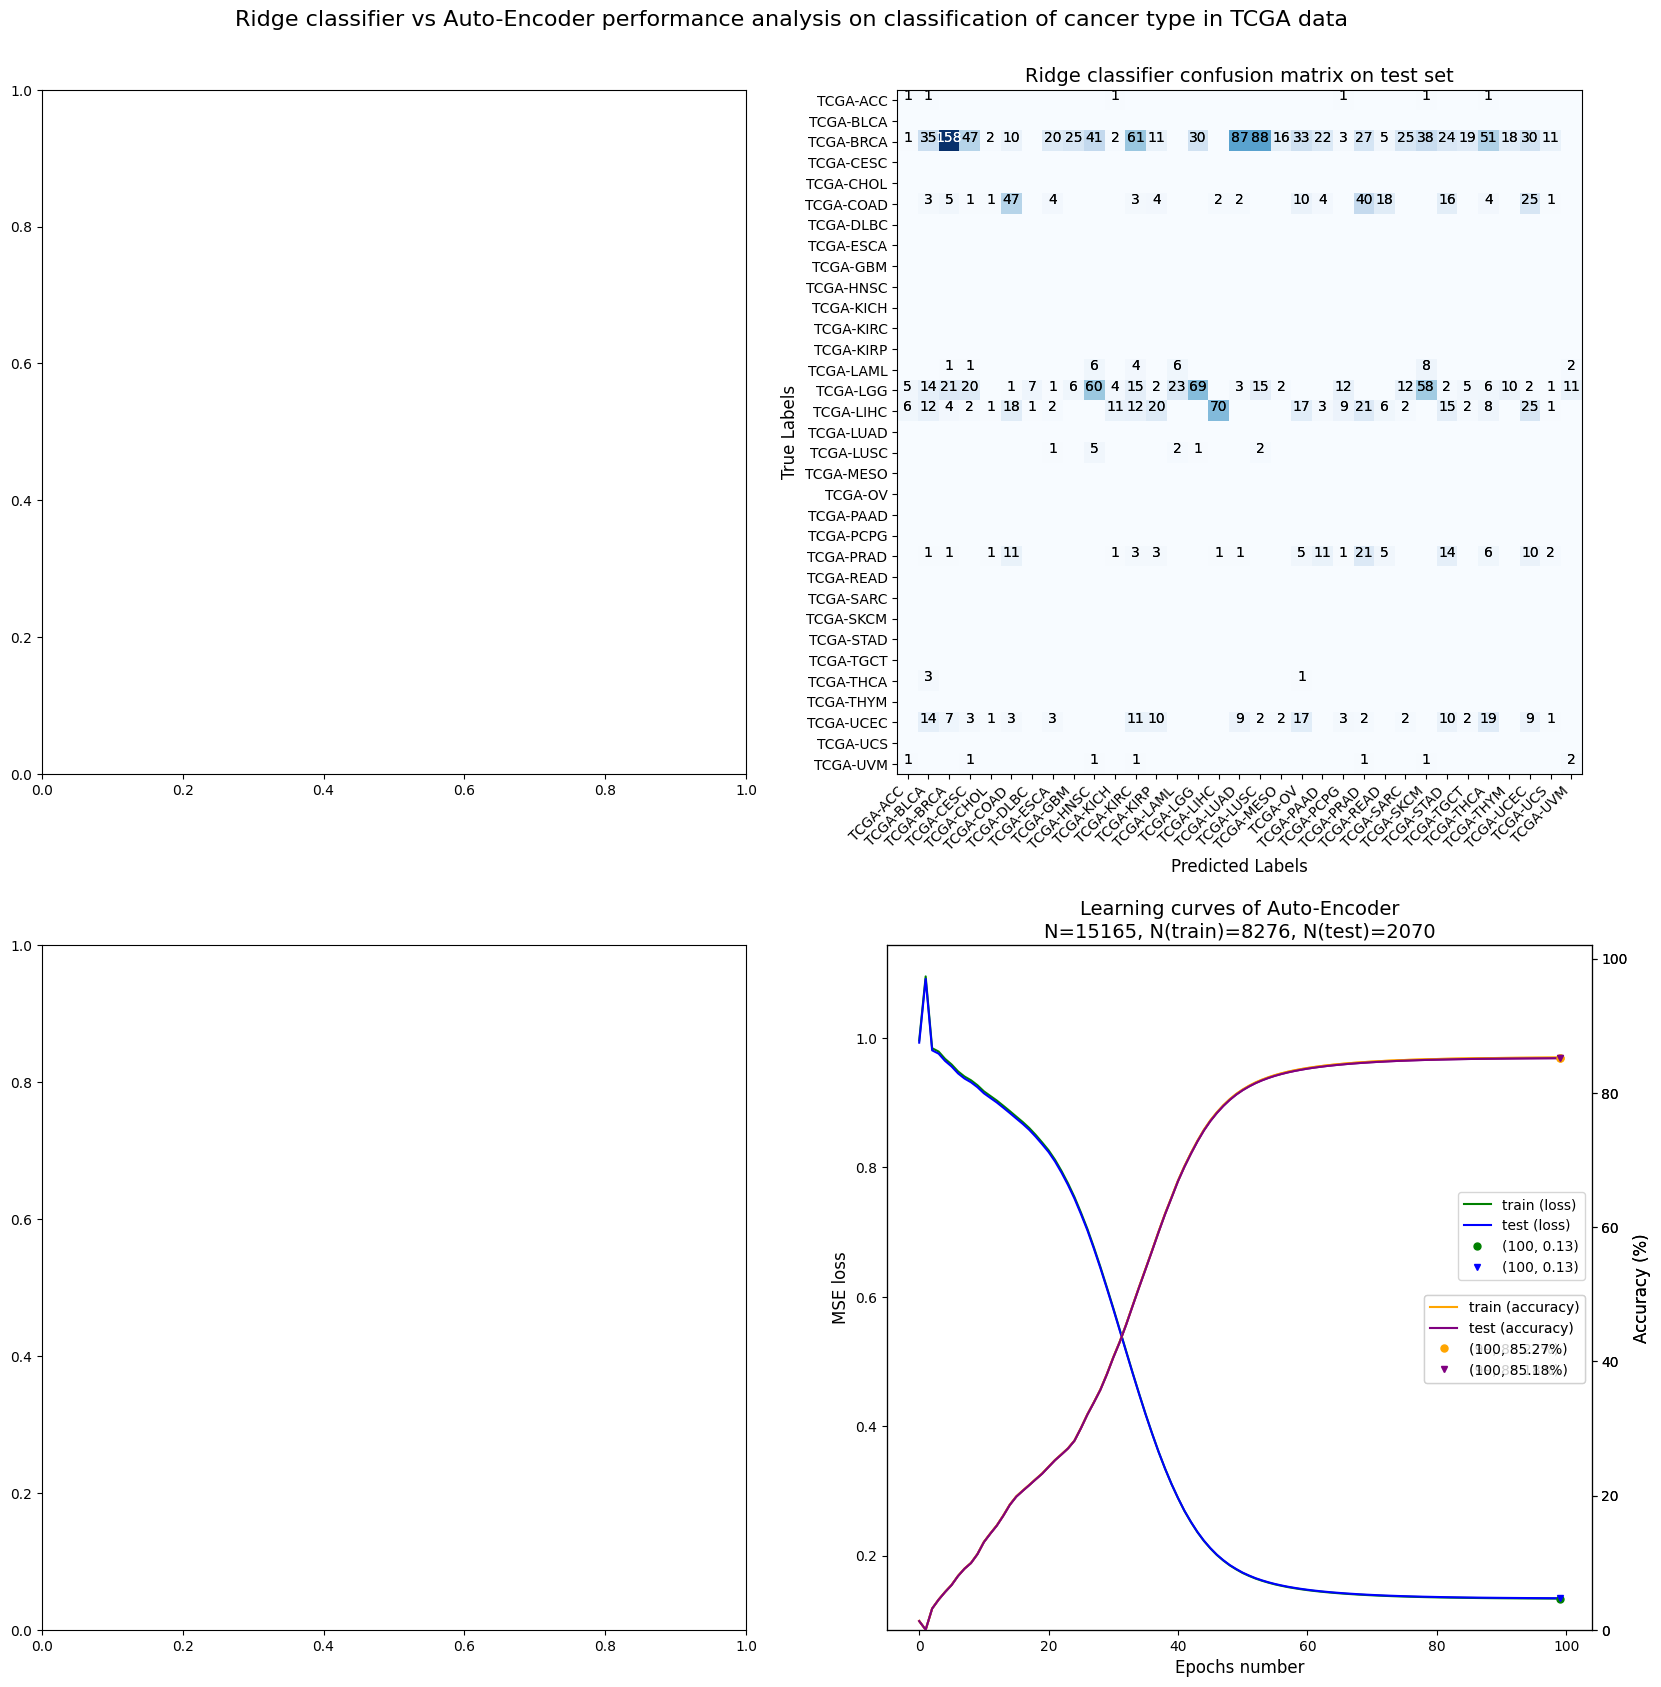

In [ ]:
fig.savefig(f'{figures_directory}/rc_ae_comparative_analysis_figures.svg', format='svg')
fig